In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_dir = r"dataset/ImageEmotion (85-15)/train"
test_dir = r"dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [4]:
preprocess_fun = tf.keras.applications.mobilenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rotation_range= 10,
                                   rescale = 1./255,
                                   validation_split = 0,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 18559 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


In [6]:
emotion_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')
mainobject_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), include_top= False, 
                                                                 weights='imagenet')
category_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), include_top= False, 
                                                                 weights='imagenet')

def emotion_model_feature_extractor(inputs):
    y = emotion_model(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def category_model_feature_extractor(inputs):
    y = category_model(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def mainobject_model_feature_extractor(inputs):
    y = mainobject_model(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model, category_model, mainobject_model):
    x, emotion_features = emotion_model(inputs)
    x, category_features = category_model(inputs)
    x, mainobject_features = mainobject_model(inputs)
    
    merged_features = tf.concat([mainobject_features, emotion_features, category_features], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output

def define_compile_model(emotionweights_path, categoryweights_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model = tf.keras.Model(inputs= inputs, outputs= emotion_model_feature_extractor(inputs))
    emotion_model.load_weights(emotionweights_path)
    category_model = tf.keras.Model(inputs= inputs, outputs= category_model_feature_extractor(inputs))
    category_model.load_weights(categoryweights_path)
    category_model.trainable = False
    mainobject_model = tf.keras.Model(inputs= inputs, outputs= mainobject_model_feature_extractor(inputs))
    mainobject_model.trainable = False
    
    classification_output = final_model(inputs, emotion_model, category_model, mainobject_model) 
    model = tf.keras.Model(inputs= inputs, outputs= classification_output)
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [7]:
emotionweights_path = r'h5 files/MobileNet-025-0.726925-0.605737.h5'
categoryweights_path = r'h5 files/MobileNet_Category-003-0.757583-0.715272.h5'
model = define_compile_model(emotionweights_path, categoryweights_path)
#model.load_weights(r'LiteEmote-018-0.767714-0.615197.h5')

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           ((None, 8),          3237064     ['input_7[0][0]']                
                                 (None, 1024))                                                    
                                                                                                  
 model (Functional)             ((None, 8),          3237064     ['input_7[0][0]']                
                                 (None, 1024))                                              

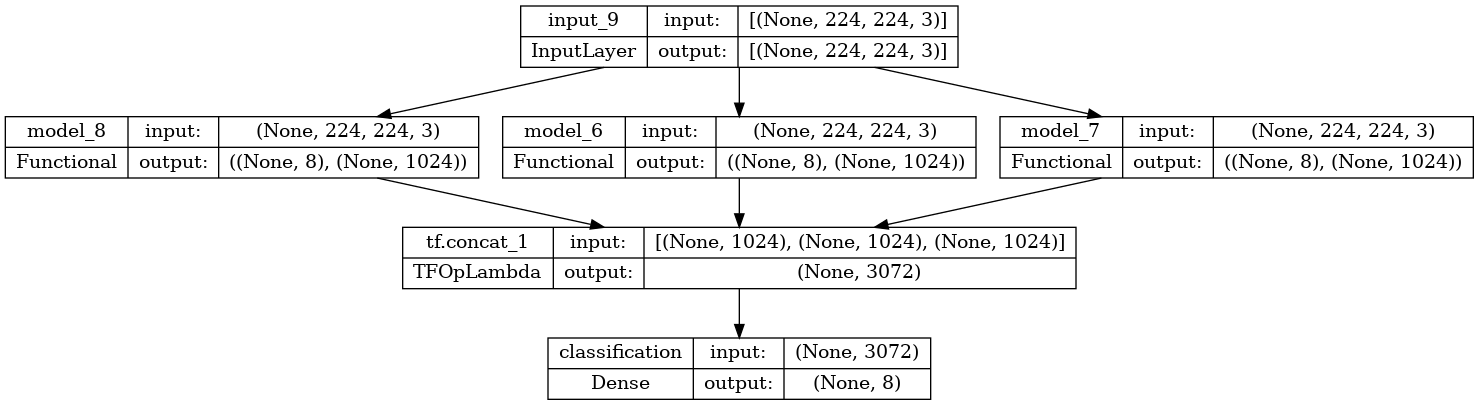

In [10]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [11]:
#for saving weights after every epoch
checkpoint = ModelCheckpoint('LiteEmote-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, 
                        monitor='val_acc',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [ ]:
#training the model
history = model.fit(train_generator,
            batch_size = BATCH_SIZE,
            epochs= 100,
            validation_data = test_generator,
            callbacks= [checkpoint]
            )

history = pd.DataFrame(history.history)

Epoch 1/100
145/145 [==============================] - ETA: 0s - loss: 0.6821 - acc: 0.7671
Epoch 1: val_acc improved from -inf to 0.61215, saving model to LiteEmote-001-0.767067-0.612145.h5
145/145 [==============================] - 492s 3s/step - loss: 0.6821 - acc: 0.7671 - val_loss: 1.1269 - val_acc: 0.6121
Epoch 2/100
145/145 [==============================] - ETA: 0s - loss: 0.6795 - acc: 0.7685
Epoch 2: val_acc improved from 0.61215 to 0.61245, saving model to LiteEmote-002-0.768468-0.612450.h5
145/145 [==============================] - 489s 3s/step - loss: 0.6795 - acc: 0.7685 - val_loss: 1.1267 - val_acc: 0.6125
Epoch 3/100
145/145 [==============================] - ETA: 0s - loss: 0.6769 - acc: 0.7670
Epoch 3: val_acc improved from 0.61245 to 0.61306, saving model to LiteEmote-003-0.767013-0.613061.h5
145/145 [==============================] - 489s 3s/step - loss: 0.6769 - acc: 0.7670 - val_loss: 1.1271 - val_acc: 0.6131
Epoch 4/100
145/145 [==============================] - 

In [9]:
json_model = model.to_json()
with open('LiteEmote.json', 'w') as json_file:
    json_file.write(json_model)
print('Saved model.')

Saved model.
